<a href="https://colab.research.google.com/github/realsanjeev/Image-generation-using-DCGAN/blob/main/GAN_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) represent a powerful framework in deep learning, introduced by Ian Goodfellow and his collaborators in 2014. GANs are designed to generate new data instances that resemble a given dataset. They achieve this through a process involving two neural networks, the generator and the discriminator, which engage in a kind of competitive game.
![GAN Architecture](https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg)
#### Core Concept

At the heart of a GAN is a dual-network system:
1. **Generator**: This network creates new data samples. It takes random noise as input and transforms it into a sample that mimics the real data distribution.
2. **Discriminator**: This network evaluates the data samples, distinguishing between real data (from the training set) and fake data (produced by the generator).

The generator and discriminator are trained simultaneously:
- The **generator** aims to produce increasingly realistic data to fool the discriminator.
- The **discriminator** tries to become better at distinguishing real data from fake data.

This adversarial process drives both networks to improve over time. The generator learns to produce more convincing samples, while the discriminator becomes better at identifying them, leading to increasingly realistic generated data.

#### Training Process

The training of GANs involves two key steps:
1. **Training the Discriminator**: The discriminator is trained on a mixture of real data and data generated by the generator. It updates its weights to maximize its ability to correctly classify real and fake samples.
2. **Training the Generator**: The generator is trained based on the feedback from the discriminator. It updates its weights to minimize the discriminator's ability to differentiate between real and generated data.

This adversarial setup is a form of a minimax game, where the generator aims to minimize the loss function, which is the discriminator's ability to correctly classify generated samples, while the discriminator aims to maximize its accuracy in distinguishing between real and fake samples.

#### Applications

GANs have revolutionized several fields due to their ability to generate high-quality data:
- **Image Generation**: GANs can create photorealistic images, leading to applications in art, design, and entertainment.
- **Image-to-Image Translation**: They are used in tasks like converting sketches to photos or day images to night images.
- **Text-to-Image Generation**: GANs can generate images from textual descriptions, enhancing fields like visual storytelling and automated content creation.
- **Data Augmentation**: GANs help in generating synthetic data for training other machine learning models, particularly when real data is scarce.

#### Challenges of GAN
- **Training Stability**: GANs are notoriously difficult to train due to the adversarial nature of their training process. Finding the right balance between the generator and discriminator is complex.
- **Mode Collapse**: The generator may produce a limited variety of outputs, failing to capture the diversity of the training data.
- **Evaluation Metrics**: Assessing the quality of generated data remains a challenge, as traditional metrics may not fully capture the quality or diversity of the results.

#### References

- [Generative Adversarial Networks - paper](https://arxiv.org/abs/1406.2661)
- [GAN - Google Developers](https://developers.google.com/machine-learning/gan/gan_structure)
- [DCGAN - Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [1]:
import os
import time
import torch
import numpy as np

from torch import nn
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib import animation

from IPython import display

print(f"Version of torch: {torch.__version__}")
print(f"Version of numpy: {np.__version__}")

Version of torch: 2.5.1+cu124
Version of numpy: 1.26.4


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"This program works on: {device}")

This program works on: cuda


In [3]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.utils as vutils

from torch.utils.data import Dataset, DataLoader

### Load Datasets

In [4]:
train_dataset = datasets.FashionMNIST(root="datasets",
                                     train=True,
                                     download=True,
                                      transform=transforms.ToTensor(),
                                      target_transform=None)

test_dataset = datasets.FashionMNIST(root="./data",
                                     train=False,
                                     download=True,
                                     transform=transforms.ToTensor(),
                                     target_transform=None)

In [27]:
BATCH_SIZE = 64
LATENT_VECTOR_SIZE = 100
N_CHANNEL = 1
# size of features maps for generator and descriminator
GENERATOR_FMS = 28
DISCRIMINATOR_FMS = 28

In [28]:
dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
real_data_batch = next(iter(dataloader))

### Visualize the Dataset

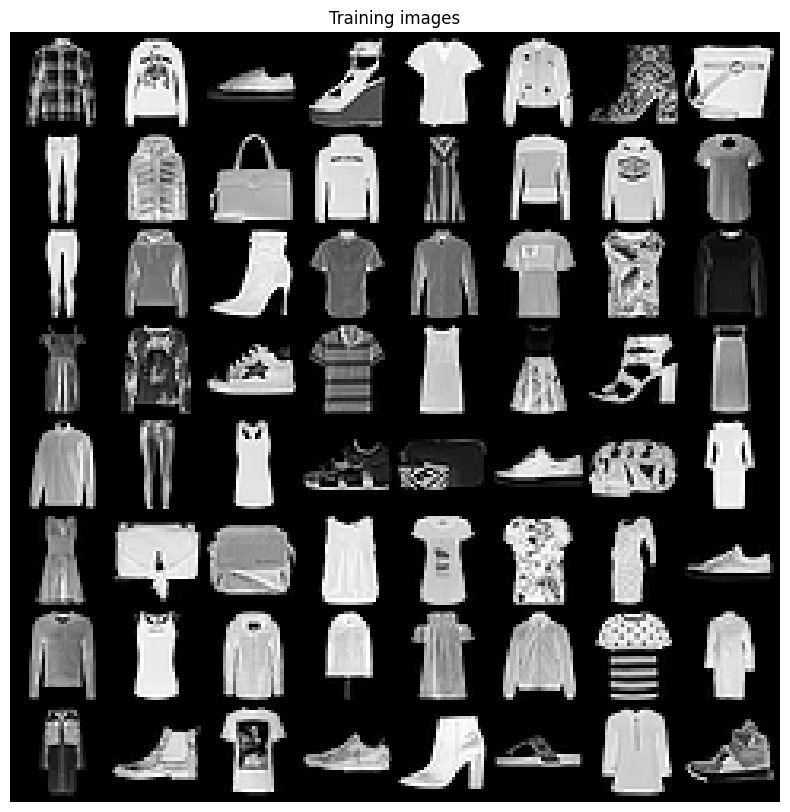

In [7]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title("Training images")
plt.imshow(np.transpose(vutils.make_grid(real_data_batch[0].to(device)[:64],
                                         padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [8]:
classes = train_dataset.classes
print(f"Total training data: {len(train_dataset)} and Total testing data: {len(test_dataset)}")
print(f"Classes: {classes}")

# for total number of batch in training dataset
print(f"{len(train_dataset)} is divided into batches: {len(train_dataset) // BATCH_SIZE}")

Total training data: 60000 and Total testing data: 10000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
60000 is divided into batches: 234


Sample data shape: torch.Size([1, 28, 28])


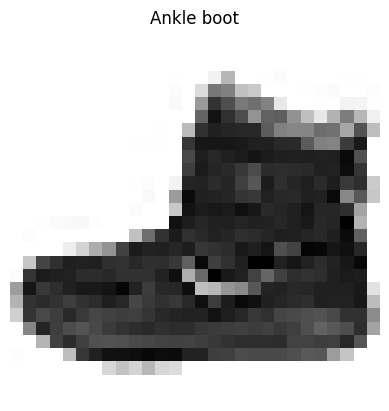

In [9]:
sample_data, sample_label = train_dataset[0]
print(f"Sample data shape: {sample_data.shape}")

fig, ax = plt.subplots()
ax.imshow(sample_data.permute(1, 2, 0), cmap=plt.cm.binary)
ax.set_title(f"{classes[sample_label]}")
ax.axis(False)
plt.show()

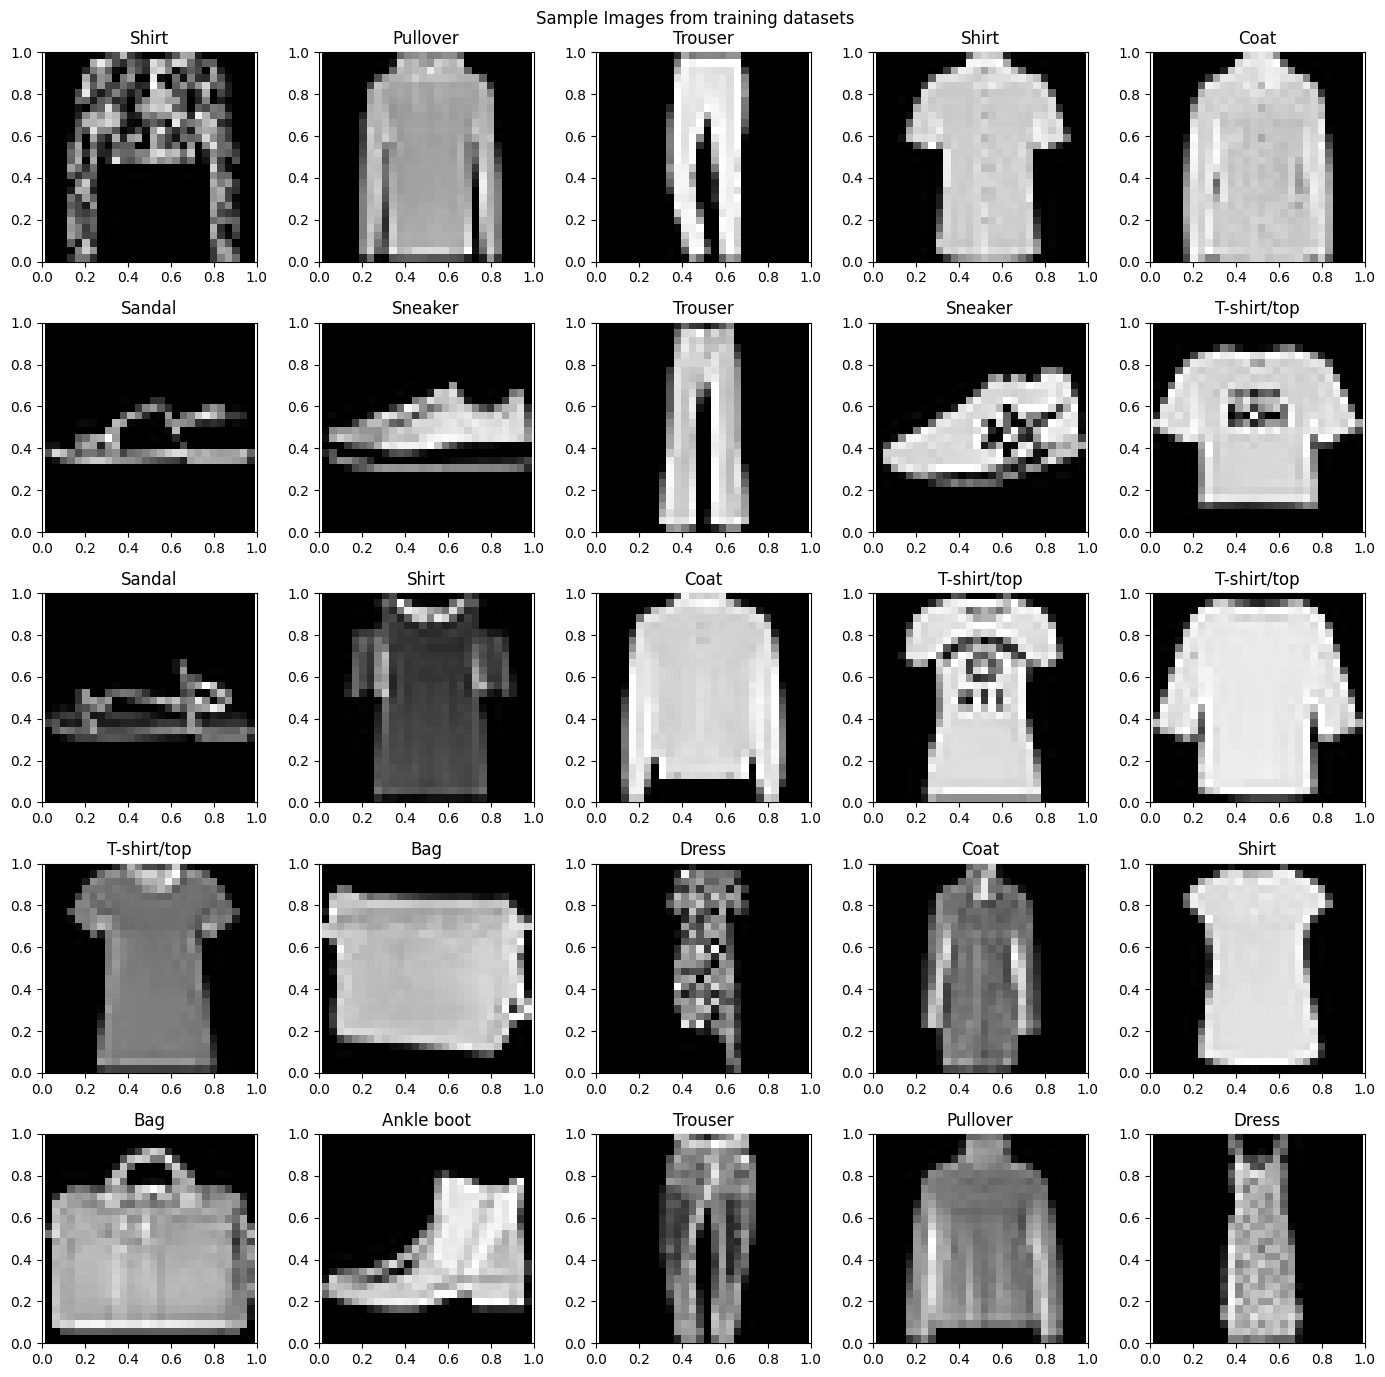

In [10]:
rows = 5
cols = 5

torch.manual_seed(42)
sample_indexes = torch.randint(0, len(train_dataset)-1, [rows*cols])

fig, ax = plt.subplots(rows, cols, figsize=(14, 14))
fig.suptitle("Sample Images from training datasets")
for i in range(rows*cols):

  ax = fig.add_subplot(rows, cols, i+1)
  sample_index = sample_indexes[i]
  # For displaying image purpose.Converting (c, h, w) to (h, w, c)
  image_data = train_dataset[sample_index ][0].permute(1, 2, 0)
  image_class_label = classes[train_dataset[sample_index][1]]
  ax.imshow(image_data, cmap="gray",)
  ax.set_axis_off()
  ax.set_title(f"{image_class_label}")

  # ax.plot()
plt.tight_layout()
plt.show()

In [11]:
# custom weight initialization function
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
  elif classname.find("BatchNorm")!= -1:
    nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
    nn.init.constant_(m.bias.data, val=0)

#### Convolution (Conv2D) Shape Calculation**
For a **standard convolutional layer**:

$$
O = \frac{(I - K + 2P)}{S} + 1
$$

where:  
- $O$ = Output size (height/width)  
- $I$ = Input size (height/width)  
- $K$ = Kernel size  
- $P$ = Padding  
- $S$ = Stride  

**Example**:
If the input is $32 \times 32$, kernel size $K = 3$, stride $S = 1$, and padding $P = 1$:

$$
O = \frac{(32 - 3 + 2(1))}{1} + 1 = 32
$$

✅ Output remains **$32 \times 32$** (same as input if $P$ is set to retain dimensions).

---

#### Transposed Convolution (ConvTranspose2D) Shape Calculation**
For a **transposed convolutional layer**:

$$
O = (I - 1) \times S - 2P + K
$$

where:  
- $O$ = Output size  
- $I$ = Input size  
- $K$ = Kernel size  
- $P$ = Padding  
- $S$ = Stride  

**Example**:
If the input is $14 \times 14$, kernel size $K = 4$, stride $S = 2$, and padding $P = 1$:

$$
O = (14 - 1) \times 2 - 2(1) + 4 = 28
$$

✅ Output becomes **$28 \times 28$**.


#### **Key Differences Between Conv and ConvTranspose**
| Parameter          | Conv2D | ConvTranspose2D |
|--------------------|--------|----------------|
| Shrinks or Expands? | Shrinks | Expands |
| Formula | $\frac{(I - K + 2P)}{S} + 1$ | $(I - 1) \times S - 2P + K$ |
| Common Usage | Feature extraction | Image generation/Upsampling |


### Generator Architecture
The **generator** in a **Generative Adversarial Network (GAN)** is responsible for generating fake data that mimics real data. Its goal is to **fool** the discriminator into classifying the fake data as real.

#### Objective:
The generator's objective is to **minimize** the discriminator’s ability to distinguish between real and fake data. It tries to generate data that is indistinguishable from real data, forcing the discriminator to incorrectly classify it as real.

The generator’s loss function is:
$$
\mathcal{L}_G = - \mathbb{E}_{z \sim p_z}[\log D(G(z))]
$$
Where:
- $G(z)$ is the fake data generated from random noise $z$.
- $D(G(z))$ is the discriminator's output for the generated data, ideally close to 1 (real).


In [12]:
class GeneratorModel(nn.Module):
    def __init__(self, ngpu: int=1):
        super(GeneratorModel, self).__init__()
        self.ngpu = ngpu
        self.sequential_layer = nn.Sequential(
            # 1. Transform latent vector (1x1) to (7x7)
            nn.ConvTranspose2d(in_channels=LATENT_VECTOR_SIZE,  # 100
                               out_channels=4*GENERATOR_FMS,   # 4*64
                               kernel_size=7,S
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(num_features=4*GENERATOR_FMS),
            nn.LeakyReLU(),

            # 2. Upsample from (7x7) to (14x14)
            nn.ConvTranspose2d(in_channels=4*GENERATOR_FMS,
                               out_channels=2*GENERATOR_FMS,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(num_features=2*GENERATOR_FMS),
            nn.LeakyReLU(),

            # 3. Upsample from (14x14) to (28x28)
            nn.ConvTranspose2d(in_channels=2*GENERATOR_FMS,
                               out_channels=N_CHANNEL,
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.Tanh()
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.sequential_layer(x)

In [13]:
generator = GeneratorModel()
generator.to(device)
generator.apply(weights_init)

GeneratorModel(
  (sequential_layer): Sequential(
    (0): ConvTranspose2d(100, 112, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(56, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [14]:
noise = torch.rand(1, 100, 1, 1).to(device)

generator.eval()
generated_image = generator(noise)
generated_image.shape

torch.Size([1, 1, 28, 28])

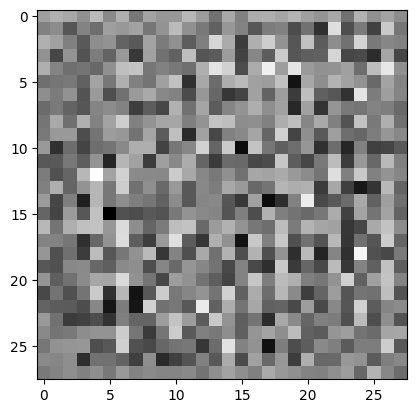

In [15]:
plt.imshow(generated_image[0][0].cpu().detach().numpy(), cmap="gray")
plt.show()

### Discriminator Architecture
The **discriminator** in a **Generative Adversarial Network (GAN)** is a binary classifier that distinguishes between **real** and **fake** data. It outputs a probability between 0 and 1, where:
- `1` means the input is real.
- `0` means the input is fake.

#### Objective:
The discriminator's goal is to maximize the probability of correctly classifying real and fake data. It tries to:
- **Maximize** the likelihood of real data being classified as real.
- **Minimize** the likelihood of fake data being classified as real.

The loss function for the discriminator is:
$$
\mathcal{L}_D = - \mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] - \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$
Where:
- $D(x)$ is the discriminator’s output for real data.
- $D(G(z))$ is the output for fake data generated by the generator $G$.

#### Adversarial Game:
- **Generator**: Tries to fool the discriminator by generating fake data that looks real.
- **Discriminator**: Tries to correctly classify data as real or fake.

This creates a **minimax game**:
$$
\min_G \max_D \mathcal{L}_D
$$
The generator minimizes the discriminator’s ability to distinguish real from fake, while the discriminator maximizes its ability to classify correctly.

### Conclusion:
The discriminator's role is to provide feedback to the generator, helping it produce more realistic data. Both models improve together in an adversarial manner until the generator creates data that is indistinguishable from real data.

In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input: N_CHANNEL x 28 x 28
            nn.Conv2d(N_CHANNEL, DISCRIMINATOR_FMS, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Second layer: DISCRIMINATOR_FMS x 14 x 14 -> DISCRIMINATOR_FMS*2 x 7 x 7
            nn.Conv2d(DISCRIMINATOR_FMS, DISCRIMINATOR_FMS * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISCRIMINATOR_FMS * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # Third layer: DISCRIMINATOR_FMS*2 x 7 x 7 -> DISCRIMINATOR_FMS*4 x 4 x 4
            nn.Conv2d(DISCRIMINATOR_FMS * 2, DISCRIMINATOR_FMS * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISCRIMINATOR_FMS * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Fourth layer: DISCRIMINATOR_FMS*4 x 4 x 4 -> DISCRIMINATOR_FMS*8 x 2 x 2
            nn.Conv2d(DISCRIMINATOR_FMS * 4, DISCRIMINATOR_FMS * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DISCRIMINATOR_FMS * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # Fifth layer: DISCRIMINATOR_FMS*8 x 2 x 2 -> 1 x 1 x 1 (final output)
            nn.Conv2d(DISCRIMINATOR_FMS * 8, 1, 1, 1, 0, bias=False),  # Change kernel size to 1x1
            nn.Sigmoid()  # Final scalar output
        )

    def forward(self, input):
        output = self.main(input)
        return output


In [17]:
torch.manual_seed(42)
discriminator = Discriminator()
discriminator.to(device)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(28, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(56, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(112, 224, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(224, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [18]:
noise = torch.rand(1, 1, 28, 28).to(device)
discriminator.eval()
discriminator_out = discriminator(noise)
discriminator_out.shape

torch.Size([1, 1, 1, 1])

In [19]:
ngpu = 1
if device=="cuda" and ngpu > 1:
  discriminator = nn.DataParallel(discriminator, list(range(ngpu)))

In [20]:
learning_rate = 0.0002
beta = 0.5
loss_fn = nn.BCELoss()
optimizer_d = torch.optim.Adam(discriminator.parameters(),
                               lr=learning_rate,
                               betas=(beta, 0.999))

optimizer_g = torch.optim.Adam(generator.parameters(),
                               lr=learning_rate,
                               betas=(beta, 0.999))

In [29]:
# Initialize empty lists to store image samples, generator losses, and discriminator losses
img_list = []
g_losses = []
d_losses = []

# Set the number of epochs and initialize the iteration count
epochs = 5
iters = 0

# Define the labels for real and fake data
real_label = 1
fake_label = 0

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Print information message before starting the training loop
print("[INFO] Starting the training Loop......")

# Training loop
for epoch in tqdm(range(epochs), desc="Epoch"):
  for i, data in tqdm(enumerate(dataloader, 0), desc="Batch", total=len(dataloader)):
    # Reset gradients for the discriminator
    discriminator.zero_grad()

    # Move real image batch to the device
    X_image_batch = data[0].to(device)
    b_size = X_image_batch.size(0)

    # Create labels for real images
    label = torch.full((b_size,), fill_value=real_label, dtype=torch.float, device=device)

    # Forward pass through the discriminator for real images
    output = discriminator(X_image_batch).view(-1)
    real_error_d = loss_fn(output, label)
    real_error_d.backward()
    d_x = output.mean().item()

    # Train with all-fake batch
    # Generate batch of latent vectors
    noise_data = torch.randn(b_size, 100, 1, 1, device=device)
    fake_image = generator(noise_data)

    # Create labels for fake images
    label.fill_(fake_label)

    # Forward pass through the discriminator for fake images
    output = discriminator(fake_image.detach()).view(-1)
    fake_error_d = loss_fn(output, label)
    fake_error_d.backward()
    d_g_x = output.mean().item()

    # Calculate the overall discriminator loss and update the discriminator
    error_d = real_error_d + fake_error_d
    optimizer_d.step()

    ############################
    #  Update G network: maximize log(D(G(z)))
    ###########################
    generator.zero_grad()
    # Create labels for real images (to be used for generator training)
    label.fill_(real_label)
    output = discriminator(fake_image).view(-1)
    error_g = loss_fn(output, label)
    error_g.backward()
    d_g_x2 = output.mean().item()
    optimizer_g.step()

    # Print training status
    if i % 100 == 0:
      print(f"[{epoch}/{epochs}] [{i}/{len(dataloader)}]\tLoss_D: {error_d.item():.3f}\tLoss_G: {error_g.item():.3f}")

    # Store generator and discriminator losses
    g_losses.append(error_g.item())
    d_losses.append(error_d.item())

    # Generate and store image samples
    if i % 100 == 0:
      with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake_image, padding=2, normalize=True))

    # Increment iteration count
    iters = iters + 1


[INFO] Starting the training Loop......


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/938 [00:00<?, ?it/s]

[0/5] [0/938]	Loss_D: 0.994	Loss_G: 1.204
[0/5] [100/938]	Loss_D: 1.019	Loss_G: 1.634
[0/5] [200/938]	Loss_D: 1.007	Loss_G: 1.200
[0/5] [300/938]	Loss_D: 0.995	Loss_G: 1.304
[0/5] [400/938]	Loss_D: 1.418	Loss_G: 0.781
[0/5] [500/938]	Loss_D: 1.129	Loss_G: 1.184
[0/5] [600/938]	Loss_D: 1.142	Loss_G: 0.907
[0/5] [700/938]	Loss_D: 0.958	Loss_G: 1.259
[0/5] [800/938]	Loss_D: 1.003	Loss_G: 0.887
[0/5] [900/938]	Loss_D: 1.102	Loss_G: 1.705


Batch:   0%|          | 0/938 [00:00<?, ?it/s]

[1/5] [0/938]	Loss_D: 1.180	Loss_G: 1.575
[1/5] [100/938]	Loss_D: 0.884	Loss_G: 1.284
[1/5] [200/938]	Loss_D: 1.025	Loss_G: 1.480
[1/5] [300/938]	Loss_D: 1.029	Loss_G: 1.225
[1/5] [400/938]	Loss_D: 1.066	Loss_G: 0.922
[1/5] [500/938]	Loss_D: 0.995	Loss_G: 1.084
[1/5] [600/938]	Loss_D: 1.114	Loss_G: 1.170
[1/5] [700/938]	Loss_D: 0.936	Loss_G: 1.056
[1/5] [800/938]	Loss_D: 0.960	Loss_G: 1.231
[1/5] [900/938]	Loss_D: 1.022	Loss_G: 1.272


Batch:   0%|          | 0/938 [00:00<?, ?it/s]

[2/5] [0/938]	Loss_D: 0.921	Loss_G: 1.273
[2/5] [100/938]	Loss_D: 1.299	Loss_G: 2.405
[2/5] [200/938]	Loss_D: 1.022	Loss_G: 1.635
[2/5] [300/938]	Loss_D: 0.939	Loss_G: 1.384
[2/5] [400/938]	Loss_D: 0.987	Loss_G: 1.234
[2/5] [500/938]	Loss_D: 1.014	Loss_G: 0.976
[2/5] [600/938]	Loss_D: 1.139	Loss_G: 1.656
[2/5] [700/938]	Loss_D: 0.965	Loss_G: 1.160
[2/5] [800/938]	Loss_D: 1.187	Loss_G: 2.049
[2/5] [900/938]	Loss_D: 0.957	Loss_G: 1.501


Batch:   0%|          | 0/938 [00:00<?, ?it/s]

[3/5] [0/938]	Loss_D: 1.021	Loss_G: 1.244
[3/5] [100/938]	Loss_D: 1.016	Loss_G: 0.942
[3/5] [200/938]	Loss_D: 0.945	Loss_G: 1.076
[3/5] [300/938]	Loss_D: 1.268	Loss_G: 1.737
[3/5] [400/938]	Loss_D: 1.083	Loss_G: 0.877
[3/5] [500/938]	Loss_D: 0.840	Loss_G: 1.312
[3/5] [600/938]	Loss_D: 0.951	Loss_G: 1.539
[3/5] [700/938]	Loss_D: 0.860	Loss_G: 1.007
[3/5] [800/938]	Loss_D: 0.882	Loss_G: 1.147
[3/5] [900/938]	Loss_D: 1.110	Loss_G: 0.725


Batch:   0%|          | 0/938 [00:00<?, ?it/s]

[4/5] [0/938]	Loss_D: 0.965	Loss_G: 1.135
[4/5] [100/938]	Loss_D: 0.855	Loss_G: 1.205
[4/5] [200/938]	Loss_D: 0.900	Loss_G: 1.135
[4/5] [300/938]	Loss_D: 1.089	Loss_G: 1.435
[4/5] [400/938]	Loss_D: 0.811	Loss_G: 1.863
[4/5] [500/938]	Loss_D: 0.920	Loss_G: 1.485
[4/5] [600/938]	Loss_D: 0.831	Loss_G: 1.285
[4/5] [700/938]	Loss_D: 0.944	Loss_G: 1.481
[4/5] [800/938]	Loss_D: 0.767	Loss_G: 1.593
[4/5] [900/938]	Loss_D: 0.835	Loss_G: 1.053


In [30]:
# save the model for future use
torch.save(discriminator.state_dict(), "discriminator.pt")
torch.save(discriminator.state_dict(), "generator.pt")

#### Visualize Loss Graph

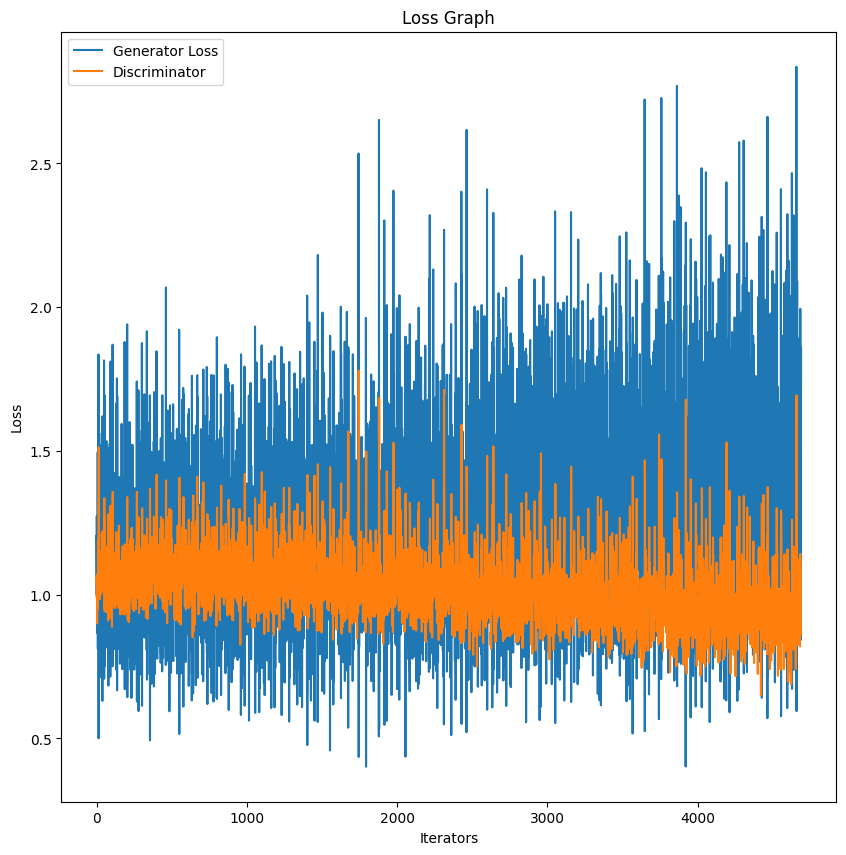

In [31]:
plt.figure(figsize=(10, 10))
plt.title("Loss Graph")
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator")
plt.ylabel("Loss")
plt.xlabel("Iterators")
plt.legend()
plt.show()

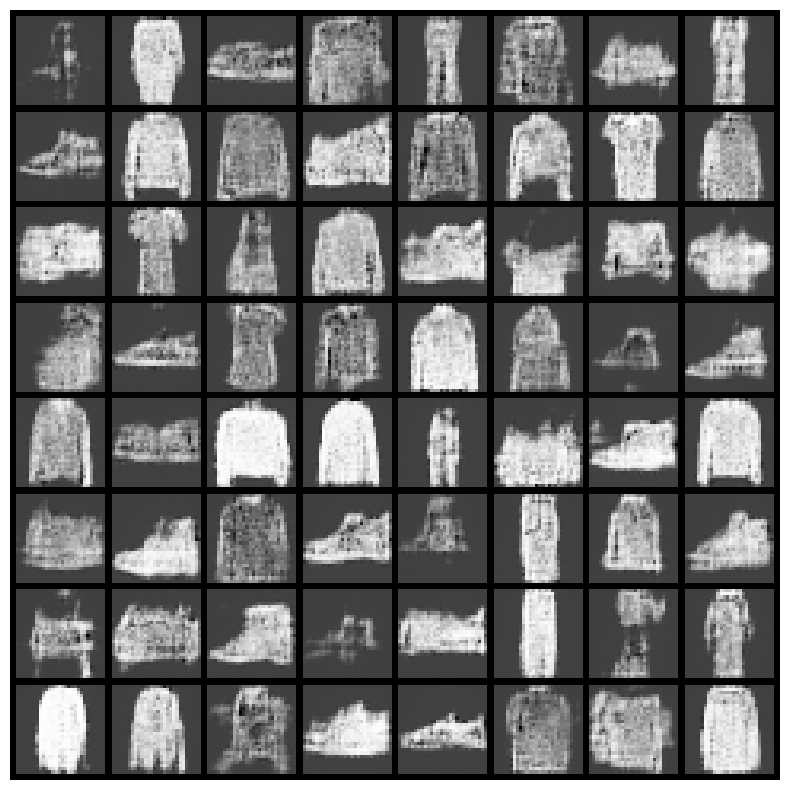

In [32]:
fig = plt.figure(figsize=(10, 10))
plt.axis(False)
ims = [[plt.imshow(np.transpose(i.cpu(), (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
display.HTML(ani.to_jshtml())

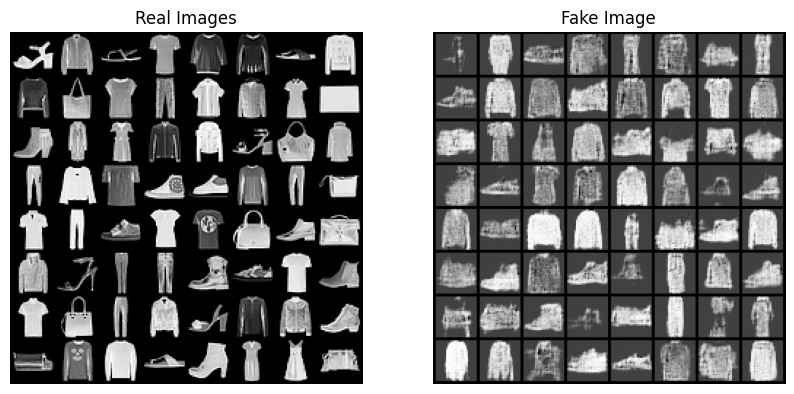

In [33]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.axis(False)
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],
                                         padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis(False)
plt.title("Fake Image")
plt.imshow(np.transpose(img_list[-1].cpu(), (1,2, 0)))

plt.show()